In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display='diagram')
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Fraud Detection Dataset.csv"

# Load the latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ranjitmandal/fraud-detection-dataset-csv",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


In [5]:
data.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

# EDA and Data Transformation

In [7]:
data.drop(columns=['Transaction_ID'],inplace=True)

In [8]:
data[data['Transaction_Amount']>30000]['Fraudulent'].value_counts()

Fraudulent
0    476
1     32
Name: count, dtype: int64

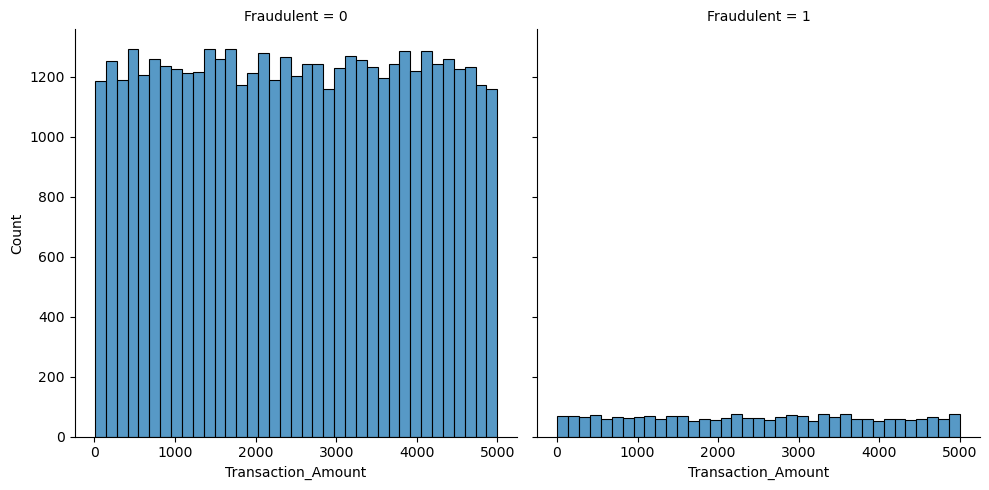

In [9]:
sns.displot(data[data['Transaction_Amount']<30000],x='Transaction_Amount',col='Fraudulent')

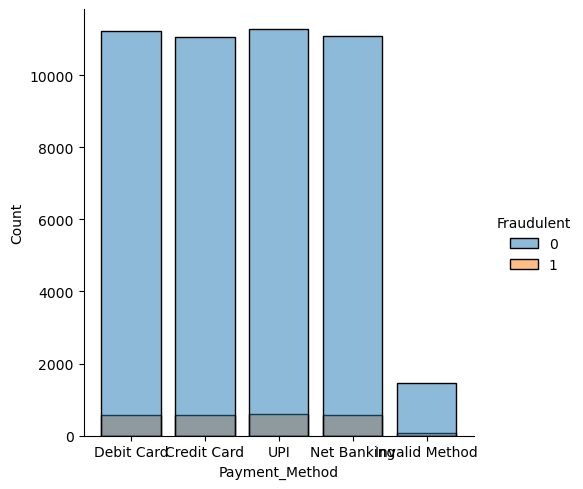

In [10]:
sns.displot(data, hue='Fraudulent',x='Payment_Method',shrink=0.8)

In [11]:
X = data.drop(columns=['Fraudulent'])
y = data['Fraudulent']

In [12]:
cat_attribs = X.select_dtypes(include='object').columns

In [13]:
num_attribs = X.select_dtypes(include=np.number).columns

In [14]:
data.isnull().sum()

User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64

# Creating a Pipeline for Transformation

In [15]:
cat_pipeline = Pipeline(
    steps=[
        ("Imputation",SimpleImputer(missing_values=np.nan,strategy="constant",fill_value="missing")),
        ("Encoder",OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]
)

In [16]:
cat_pipeline

Pipeline(steps=[('Imputation',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('Encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [17]:
num_pipeline = Pipeline(
    steps=[
        ("Imputation",SimpleImputer(missing_values=np.nan,strategy="mean")),
        ("Scaler",StandardScaler())
    ]
)

In [18]:
num_pipeline

Pipeline(steps=[('Imputation', SimpleImputer()), ('Scaler', StandardScaler())])

In [19]:
preprocessor = ColumnTransformer(
    [("categorical",cat_pipeline,cat_attribs),
     ("numerical",num_pipeline,num_attribs)]
)

In [24]:
pipe = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("undersampler", RandomUnderSampler(random_state=42)),
        ("pca", PCA(n_components=0.95)),
        ("classifier", XGBClassifier())
    ]
)

In [25]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(ste...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# Training the model and getting some predictions

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [27]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(ste...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [28]:
y_pred = pipe.predict(X_test)

## Accuracy of the model

### Accuracy on Test Data

In [29]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_curve,auc,precision_recall_curve
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.51      0.67     16021
           1       0.05      0.51      0.09       809

    accuracy                           0.51     16830
   macro avg       0.50      0.51      0.38     16830
weighted avg       0.91      0.51      0.64     16830

Accuracy: 0.5106357694592989


Text(50.722222222222214, 0.5, 'Actual')

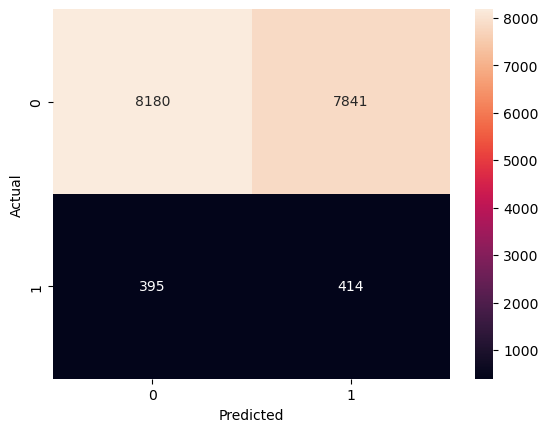

In [30]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Accuracy on Train Data

In [31]:
y_pred = pipe.predict(X_train)

In [32]:
print(classification_report(y_train, y_pred))
print("Accuracy:", accuracy_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69     32469
           1       0.10      1.00      0.18      1701

    accuracy                           0.55     34170
   macro avg       0.55      0.76      0.44     34170
weighted avg       0.96      0.55      0.67     34170

Accuracy: 0.5535850160959906


Text(50.722222222222214, 0.5, 'Actual')

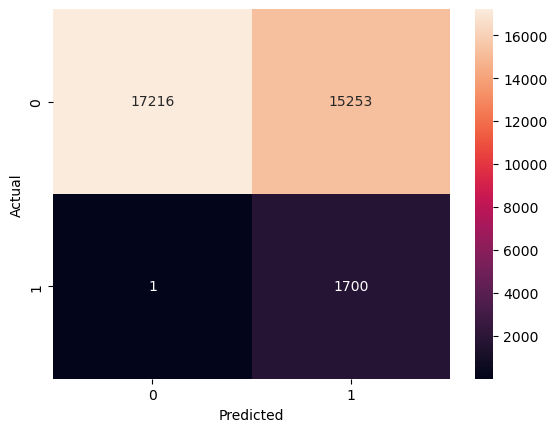

In [33]:
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Plotting Curves

### ROC Curve

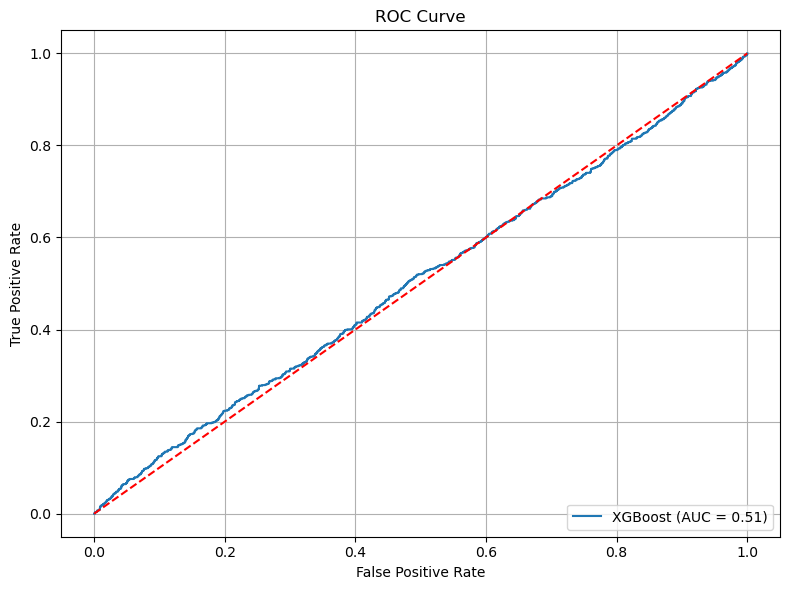

In [34]:
y_prob = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid()
plt.show()

### Plotting Precision Recall Curve

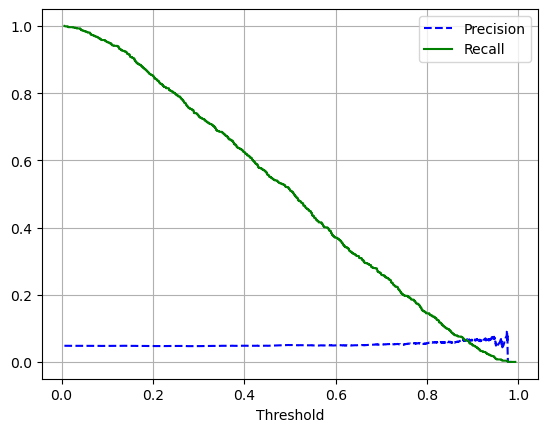

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid
    plt.xlabel('Threshold')
    plt.grid()
    plt.legend()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Selecting optimal threshold

In [36]:
threshold_ = thresholds[np.argmax(recalls <= 0.1)]
y_pred = (y_prob >= threshold_)

Text(50.722222222222214, 0.5, 'Actual')

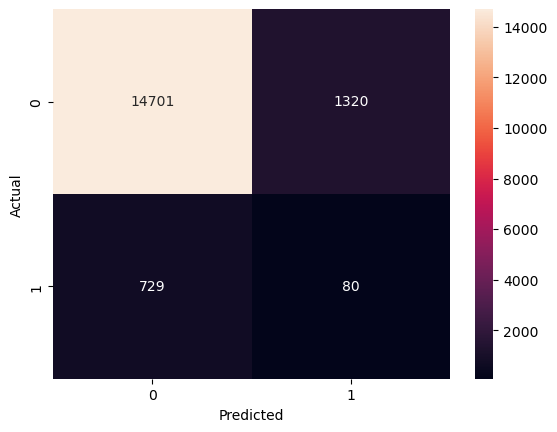

In [37]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

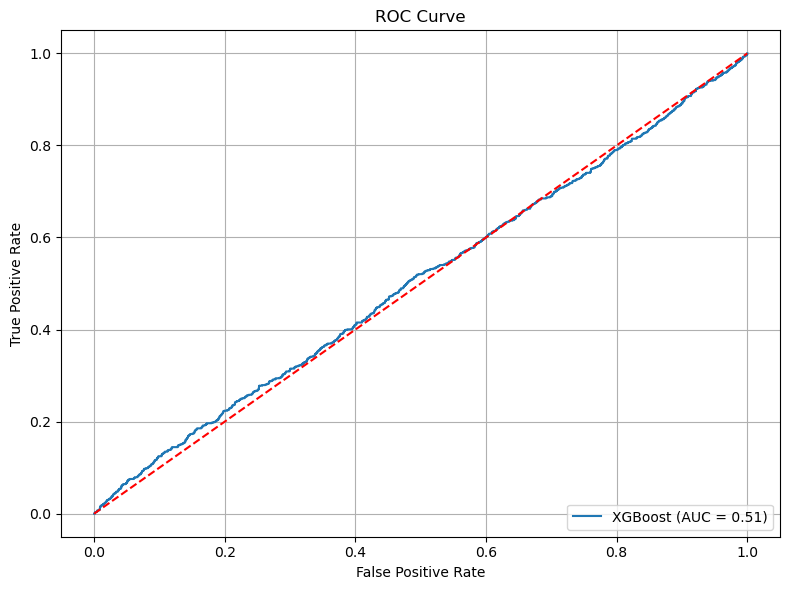

In [38]:
y_prob = pipe.predict_proba(X_test)[:, 1]
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid()
plt.show()